In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
import logging
import os
# Set both HTTP and HTTPS proxies
os.environ["HTTP_PROXY"]  = "http://proxy.isoad.isogmbh.de:81"
os.environ["HTTPS_PROXY"] = "http://proxy.isoad.isogmbh.de:81"

# 1. EINMALIGER DOWNLOAD (Außerhalb der Schleife)
tickers = ['AAPL', 'SPY']
df_raw_multi = yf.download(tickers, start='2021-06-01', end='2025-01-01')

# 2. BASIS-BERECHNUNG (Log-Returns & Volumen)
# Wir berechnen hier nur die Roh-Features, die keine Roll-Fenster nutzen
df_close_log = np.log(df_raw_multi['Close'] / df_raw_multi['Close'].shift(1))
df_vol_log = np.log(df_raw_multi['Volume']).diff()

# Echte AAPL-Preise für P&L-Berechnung
aapl_open = df_raw_multi['Open']['AAPL']
aapl_close = df_raw_multi['Close']['AAPL']

# 3. DIE SCHLEIFE
test_dates = df_close_log['2024-01-01':].index
portfolio_value = 10000.0
current_pos = 0
entry_price = None
THRESHOLD = 0.000553
FEE = 0.0005
log_file = 'walk_forward_log.csv'

# Log-Header
with open(log_file, 'w') as f:
    f.write("date,pred_momentum,signal,trade_return,portfolio_value\n")

for i, today in enumerate(test_dates):
    # --- DATEN-FENSTER FÜR HEUTE ERSTELLEN ---
    df_list = []
    for t in tickers:
        # Nur Daten bis 'today'
        mask = df_close_log.index <= today
        
        # Preis-Kanäle
        df_list.append(pd.DataFrame({
            'ds': df_close_log.index[mask],
            'unique_id': f'{t}_price',
            'y': df_close_log[t][mask]
        }))
        # Volumen-Kanäle
        df_list.append(pd.DataFrame({
            'ds': df_vol_log.index[mask],
            'unique_id': f'{t}_vol',
            'y': df_vol_log[t][mask]
        }))

    df_step = pd.concat(df_list).dropna()
    
    # Momentum-Target berechnen (NUR auf den Daten bis heute!)
    #df_step['y_rolling'] = df_step.groupby('unique_id')['y'].transform(lambda x: x - x.rolling(5).mean())
    #df_step = df_step.dropna().rename(columns={'y': 'y_raw', 'y_rolling': 'y'})
    
    # --- MODELL-TRAINING ---
    model = PatchTST(
        h=7,
        input_size=10,
        patch_len=2,
        stride=1,
        max_steps=300,
        learning_rate=1e-4,
        early_stop_patience_steps=3,
        val_check_steps=50,
        optimizer_kwargs={'weight_decay': 0.01},
        accelerator='gpu',
        devices=1
    )

    nf = NeuralForecast(models=[model], freq='D')
    nf.fit(df=df_step, val_size=20)
    # Prediction für den nächsten Tag
    forecast = nf.predict(df=df_step)
    # Wir nehmen den ersten Tag des Horizonts (t+1)
    pred_momentum = forecast.query("unique_id == 'AAPL_price'").iloc[0]['PatchTST']
    print(forecast)
    # Signal Logik
    signal = 0
    if pred_momentum > THRESHOLD: signal = 1
    elif pred_momentum < -THRESHOLD: signal = -1
    
    # --- ABRECHNUNG MIT ECHTEN PREISEN ---
    trade_return = 0.0
    
    if signal != current_pos:
        # 1. Bestehende Position schließen zum heutigen Close
        if current_pos != 0 and entry_price is not None:
            close_today = aapl_close.loc[today]
            trade_return = current_pos * (close_today - entry_price) / entry_price
            portfolio_value *= (1 + trade_return)
        
        # 2. Kosten bei Signalwechsel (Roundtrip-Gebühr)
        portfolio_value *= (1 - FEE)
        
        # 3. Neue Position eröffnen zum Open des nächsten Tages
        if signal != 0 and i + 1 < len(test_dates):
            next_day = test_dates[i + 1]
            entry_price = aapl_open.loc[next_day]
        else:
            entry_price = None
        
        current_pos = signal
    
    print(f"{today.date()} | Pred: {pred_momentum:.5f} | Signal: {signal} | "
          f"Pos: {current_pos} | Return: {trade_return:+.4f} | Port: {portfolio_value:.2f}")
    with open(log_file, 'a') as f:
        f.write(f"{today.date()},{pred_momentum},{signal},{trade_return},{portfolio_value}\n")

# Letzte offene Position zum letzten Close schließen
if current_pos != 0 and entry_price is not None:
    last_close = aapl_close.loc[test_dates[-1]]
    final_return = current_pos * (last_close - entry_price) / entry_price
    portfolio_value *= (1 + final_return)
    portfolio_value *= (1 - FEE)
    print(f"\nFinal close | Return: {final_return:+.4f} | Port: {portfolio_value:.2f}€")

print(f"\n=== Endwert: {portfolio_value:.2f}€ (Start: 10000€, Rendite: {(portfolio_value/10000-1)*100:+.2f}%) ===")

[*********************100%***********************]  1 of 1 completed


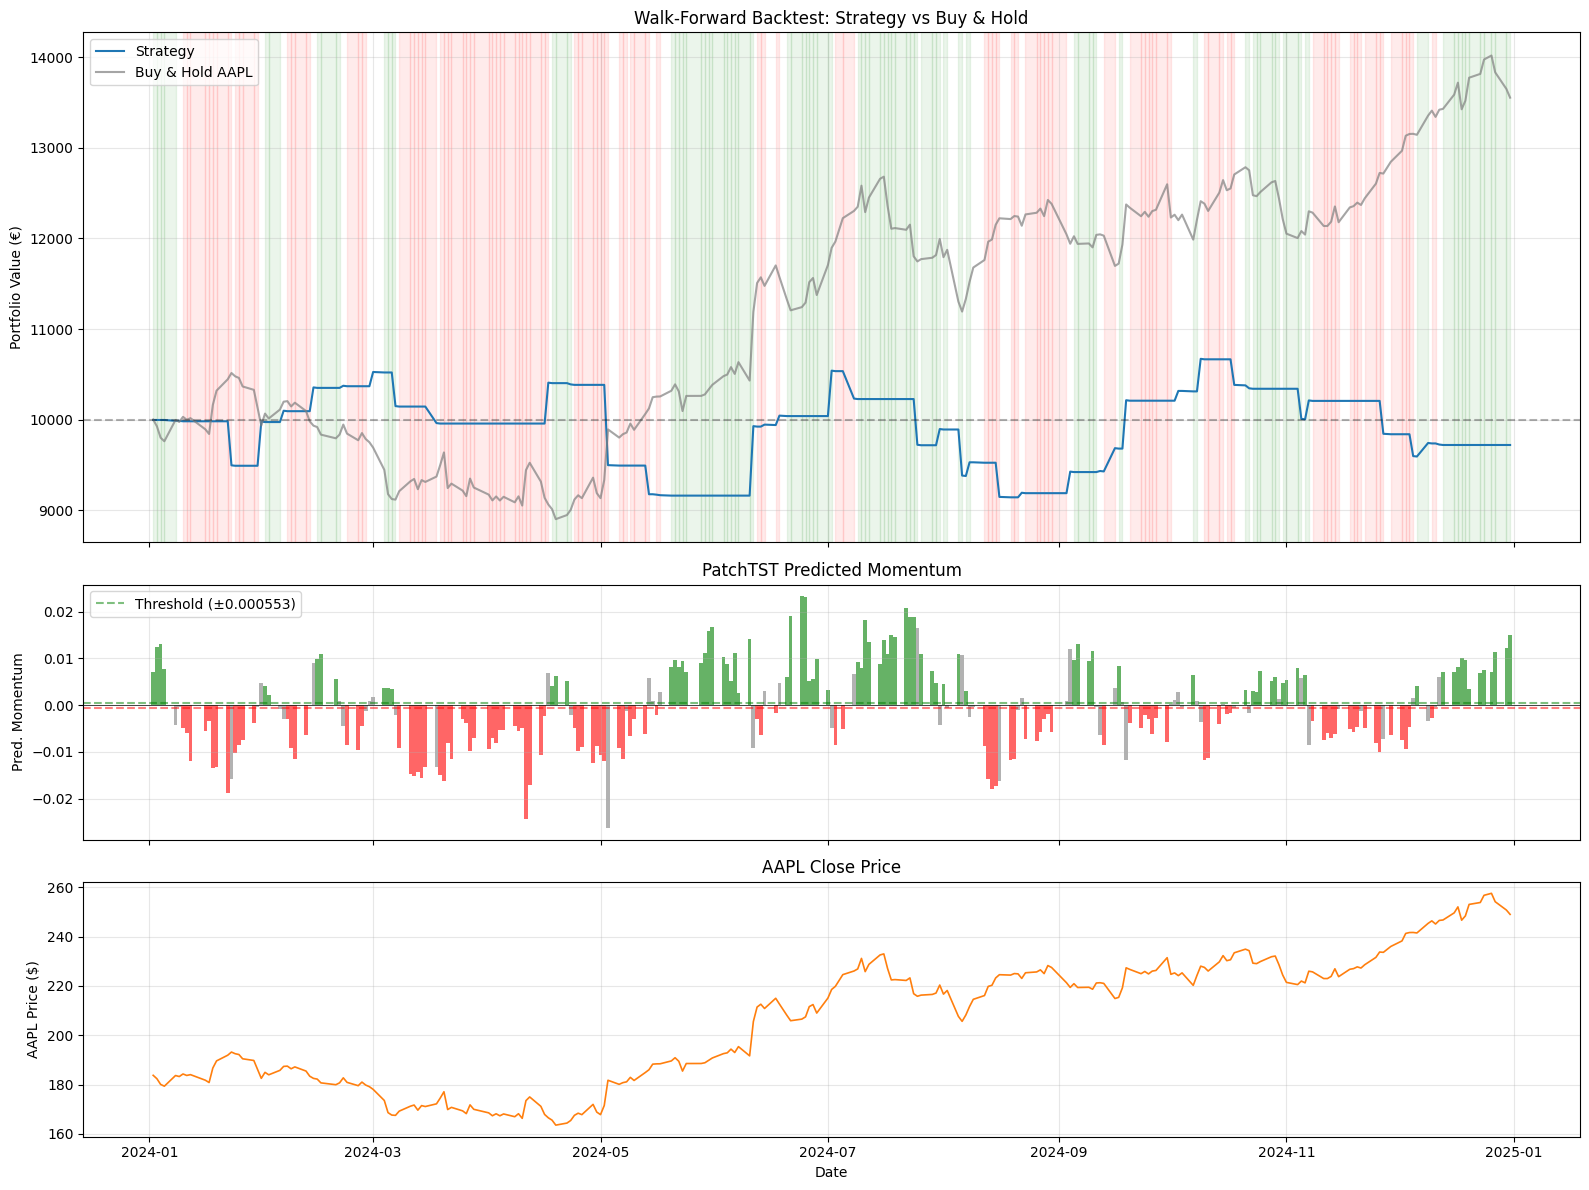

Strategy Return:   -2.81%
Buy & Hold Return: +35.56%
Signal Changes:    90
Long/Short/Flat:   85 / 104 / 63 days


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os
os.environ["HTTP_PROXY"]  = "http://proxy.isoad.isogmbh.de:81"
os.environ["HTTPS_PROXY"] = "http://proxy.isoad.isogmbh.de:81"

# Log einlesen
df_log = pd.read_csv('walk_forward_log.csv', parse_dates=['date'], index_col='date')

# AAPL Close-Preise für den gleichen Zeitraum
df_aapl = yf.download('AAPL', start='2021-06-01', end='2025-01-01')
aapl_close = df_aapl['Close'].squeeze()
aapl_bt = aapl_close.loc[df_log.index]

# Buy & Hold normalisiert auf gleichen Startwert
bh_normalized = aapl_bt / aapl_bt.iloc[0] * 10000

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True,
                         gridspec_kw={'height_ratios': [2, 1, 1]})

# --- Plot 1: Portfolio P&L vs Buy & Hold ---
ax1 = axes[0]
ax1.plot(df_log.index, df_log['portfolio_value'], label='Strategy', linewidth=1.5, color='tab:blue')
ax1.plot(bh_normalized.index, bh_normalized.values, label='Buy & Hold AAPL', linewidth=1.5, color='tab:gray', alpha=0.7)
ax1.axhline(10000, color='black', linestyle='--', alpha=0.3)
ax1.set_ylabel('Portfolio Value (€)')
ax1.set_title('Walk-Forward Backtest: Strategy vs Buy & Hold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Signals als Hintergrundfarbe
for j in range(len(df_log) - 1):
    sig = df_log['signal'].iloc[j]
    if sig == 1:
        ax1.axvspan(df_log.index[j], df_log.index[j+1], alpha=0.08, color='green')
    elif sig == -1:
        ax1.axvspan(df_log.index[j], df_log.index[j+1], alpha=0.08, color='red')

# --- Plot 2: Predicted Momentum + Threshold ---
ax2 = axes[1]
colors = ['green' if s == 1 else 'red' if s == -1 else 'gray' for s in df_log['signal']]
ax2.bar(df_log.index, df_log['pred_momentum'], color=colors, alpha=0.6, width=1)
ax2.axhline(0.000553, color='green', linestyle='--', alpha=0.5, label=f'Threshold (±{0.000553})')
ax2.axhline(-0.000553, color='red', linestyle='--', alpha=0.5)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_ylabel('Pred. Momentum')
ax2.set_title('PatchTST Predicted Momentum')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# --- Plot 3: AAPL Kurs ---
ax3 = axes[2]
ax3.plot(aapl_bt.index, aapl_bt.values, color='tab:orange', linewidth=1.2)
ax3.set_ylabel('AAPL Price ($)')
ax3.set_title('AAPL Close Price')
ax3.set_xlabel('Date')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('walk_forward_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistiken
total_return = (df_log['portfolio_value'].iloc[-1] / 10000 - 1) * 100
bh_return = (aapl_bt.iloc[-1] / aapl_bt.iloc[0] - 1) * 100
n_trades = (df_log['signal'].diff().fillna(0) != 0).sum()
long_days = (df_log['signal'] == 1).sum()
short_days = (df_log['signal'] == -1).sum()
flat_days = (df_log['signal'] == 0).sum()

print(f"Strategy Return:   {total_return:+.2f}%")
print(f"Buy & Hold Return: {bh_return:+.2f}%")
print(f"Signal Changes:    {n_trades}")
print(f"Long/Short/Flat:   {long_days} / {short_days} / {flat_days} days")